# A guide for using the Hilbert-Huang Transform in Machine Learning

## Abstract

The `Hilbert–Huang transform` (`HHT`) is a time series analysis technique specifically designed to handle nonlinear and non-stationary time series data. In contrast to other traditional spectral analysis methods, `HHT` is data-adaptive which leads to more physically meaningful components. This data driven decomposition comes at the expense of computational complexity, it is this computation factor which has seen wavelets dominate signal processing pipelines for filtering/de-noising applications. Contrast to conventional spectral analysis methods such as fourier transform and the wavelet transform, the `HHT` does not lose temporal information after transformation. This is a key advantage over alternative time series representation as input into a machine learning models. This paper attempts to showcase a comparative study of `Hilbert–Huang transform`, `Fourier transform` and `wavelet transform` as input representations into machine learning models. In performing the analyses, it is empirically demonstrated that the `Hilbert spectrum` containing estimations for **energy**, **time** and **frequency**, have a learning advantage over alternative representations when dealing with signals which contain nonlinear and/or nonstationary phenomena.   

## Contents

The contents of this Jupyter Notebook are as follows:

1. Introduction 
2. Background
    1. Fourier Transform
    2. Wavelet Transform
    3. Short-Time Fourier Transform (STFT)
3. Hilbert Spectral Analysis
    1. Hilbert Transform
    2. Empirical mode decomposition (EMD)
    3. Empirical mode Reconstruction
    4. Hilbert–Huang transform
4. Practical Machine Learning Applications
    1. UCI-HAR dataset
    2. ECG Dataset
    3. Comparative Analysis 
5. Discussion
6. Conclusions


## Introduction

The following chapter will present background knowledge on Fourier Transform, Wavelet Transform and Short-Time Fourier Transform (STFT), however the 


In this artical we will focus on implementation and theory of the `Hilbert–Huang transform`, related topics  



<div class="alert alert-block alert-warning">
<b>Warning:</b> This guide has been developed and tested using the conda environment <b>`hht`</b>, it is strongly advised to install this enviroment prior to execution of Jupyter Notebook.  
</div>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pl

from scipy.signal import hilbert, spectrogram
from PyEMD import EMD
from sklearn.preprocessing import MinMaxScaler

import pywt

from src.HHT import *
from src.biosignal_filter import denoise_biowave

### Custom Functions

In [2]:
def color_map():
    '''Here we define a color map where 0 == white'''
    cmap = plt.cm.cividis

    # Get the colormap colors
    my_cmap = cmap(np.arange(cmap.N))

    # Set alpha
    my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

    # Create new colormap
    my_cmap = ListedColormap(my_cmap)
    
    return my_cmap

def plot_wavelet(ax, time, signal, scales, waveletname = 'cmor', 
                 cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    im = ax.contourf(time, np.log2(period), 
                     np.log2(power), 
                     contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
def plot_HHT(ax, fs, signal, cmap = plt.cm.seismic, title = ''):


    T, F, spec_2d, spec_1d = Hilbert_spectrum(signal, fs, freq_div = 2, 
                                    n_components = 4, 
                                    frequency_resolution = .2)

    ax.set_title(title)
    ax.pcolormesh(T, F, spec_2d, cmap= cmap)
    ax.set_xlabel('time (sec)')
    ax.set_ylabel('Frequency (Hz)')

### Generate Synthetic non-stationary Time Series

To initally test the EMD and full HHT we will initally generate synthetic non-stationary time series data fromt he following equation, to ensure the functions are operating as expected.
$$S(t)= 5 + sin(0.05*t) + sin(6*t) + cos(3*t)$$

In [7]:
# define sample frequency of signal
fs = 100
n_samples = 1500
# build elapsed time vector
t = np.linspace(0, (1/fs)*n_samples, num=int((1/fs)*n_samples/(1/fs))+1)
# build Synthetic non-stationary signal
s = np.sin(0.05*t)+np.sin(6*t)+np.cos(3*t)

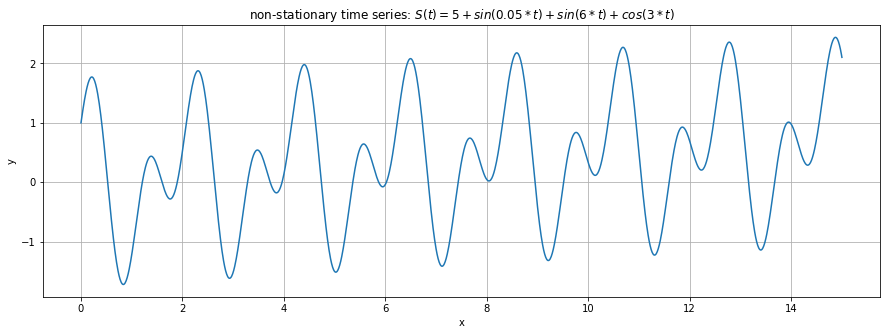

In [8]:
plt.figure(figsize=(15,5))
plt.title('non-stationary time series: $S(t)=5 + sin(0.05*t) + sin(6*t) + cos(3*t)$')
plt.plot( t, s )
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

## 

The Fourier Transform of a real-valued signal is complex-symmetric. This implies that the content at negative frequencies are redundant with respect to the positive frequencies. 


In this section, we will provide the background information required to Understand the relationship between `analytic signal`, `Hilbert transform` and `FFT`. 

### Fourier Transform 

[Fourier Transform](https://www.gaussianwaves.com/2015/11/interpreting-fft-results-complex-dft-frequency-bins-and-fftshift/) of a real-valued signal is ***complex-symmetric***. It implies that the content at negative frequencies are redundant with respect to the positive frequencies.




The `Fourier Transform` transforms information from the **time-domain** to the **frequency domain**. The spurs in the frequency spectrum indicate the most occurring frequencies in the signal. The peaks in the frequency spectrum indicate the most occurring frequencies in the signal. The larger and sharper a peak is, the more prevalent a frequency is in a signal. Fectures can be extractred from this frequency representation (*such as the top 10 largest amplitude peaks in the specturm, in this case both location of the spur (frequency-value) and height (amplitude) of the peak would be inputted into the model*) or the entire specturm could be feed into a neural network. These simple approach will work very well when the frequency spectrum is stationary i.e. there is no time dependance in the singal 




### Fourier Transform

The Fourier series is made up of sines and cosines; the Fourier transform is a generalisation of
this series, and is made up of exponentials and complex numbers. The `Fourier Transform` transforms information from the **time-domain** to the **frequency domain**. This is achieved by computing the dot-product between the time series we want to analysis, with a series of sine-waves with different frequencies. We are able to determine which frequencies are present in a signal. If the dot-product between our time series signal and a sine wave of a certain frequency results in a large amplitude this means that there is a lot of overlap between the two signals, and our signal contains this specific frequency. 


The dot product here enabling us to measure of how much two vectors / signals overlap.      
    


 This is of course because the dot product is a measure of how much two vectors / signals overlap.




The peaks in the frequency spectrum indicate the most occurring frequencies in the signal. The larger and sharper a peak is, the more prevalent a frequency is in a signal. The location (frequency-value) and height (amplitude) of the peaks in the frequency spectrum then can be used as input for Classifiers like Random Forest or Gradient Boosting.




Unlike the Fourier transform, which transforms information from the time domain into the frequency domain, the HHT does not lose temporal information after transformation, i.e. energy–frequency information is maintained in the time domain. 



The wavelet and Fourier transforms
have been the traditional spectral analysis methods, but they are predicated on a priori selection of
basis functions that are either of infinite length or have fixed finite widths

The central idea of `HHT` is the `empirical mode decomposition`, which decomposes a signal into basis functions called the `intrinsic mode functions` (`IMFs`). The `Hilbert transform` can then be applied to the `IMFs` to generate an `energy–time–frequency spectrum` called the `Hilbert spectrum`. 




The first step is to decompose the orginal signal into a number of components. `Empirical mode decomposition` (`EMD`) is a data-adaptive multi-resolution technique to decompose a signal into a finite number of `intrinsic mode functions` (`IMFs`). IMFs are time-varying mono-component (*single frequency*) functions. The signal is decomposed into `IMFs` in such that the highest frequency components of each event in the signal is captured by the first `IMF`.

The second step of `HHT` is the `Hilbert transform` that produces an orthogonal pair for each IMF that is phase shifted by 90 degrees. Each IMF set and its orthogonal pair can be used to **estimate** the **instantaneous variation** in **magnitude** and **frequency** of the IMF with respect to **time**. Thus, `HHT` is very useful to extract information from nonlinear and nonstationary time series data such as physiological signals.

In [9]:
from scipy.fft import fft, fftfreq, fftshift

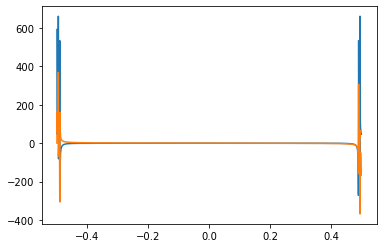

In [10]:
sp = fft(s)
freq = fftshift(fftfreq(t.shape[-1]))

plt.plot(freq, sp.real, freq, sp.imag)

### Hilbert Transform

The `Hilbert transform` is a specific linear operator which 


The `Hilbert transform` facilitates the formation of the [analytic signal](https://en.wikipedia.org/wiki/Analytic_signal). The analytic signal is useful in the area of communications, particularly in bandpass signal processing. The toolbox function hilbert computes the Hilbert transform for a real input sequence x and returns a complex result of the same length, y = hilbert(x), where the real part of y is the original real data and the imaginary part is the actual Hilbert transform. y is sometimes called the analytic signal, in reference to the continuous-time analytic signal. A key property of the discrete-time analytic signal is that its Z-transform is 0 on the lower half of the unit circle. Many applications of the analytic signal are related to this property; for example, the analytic signal is useful in avoiding aliasing effects for bandpass sampling operations. The magnitude of the analytic signal is the complex envelope of the original signal.

The Hilbert transform is related to the actual data by a 90-degree phase shift; sines become cosines and vice versa. To plot a portion of data and its Hilbert transform, use


In mathematics and in signal processing, the Hilbert transform is a specific linear operator that takes a function, u(t) of a real variable and produces another function of a real variable H(u)(t). This linear operator is given by convolution with the function {\displaystyle 1/(\pi t)}{\displaystyle 1/(\pi t)} (see § Definition). The Hilbert transform has a particularly simple representation in the frequency domain: It imparts a phase shift of ±90° (π⁄2 radians) to every frequency component of a function, the sign of the shift depending on the sign of the frequency (see § Relationship with the Fourier transform). The Hilbert transform is important in signal processing, where it is a component of the analytic representation of a real-valued signal u(t). The Hilbert transform was first introduced by David Hilbert in this setting, to solve a special case of the Riemann–Hilbert problem for analytic functions.

$$ x_a = F^{-1}(F(x) 2U) = x + i y $$

The analytic signal x_a(t) of signal x(t) is:

where F is the Fourier transform, U the unit step function, and y the Hilbert transform of x. [1]

In other words, the negative half of the frequency spectrum is zeroed out, turning the real-valued signal into a complex signal. The Hilbert transformed signal can be obtained from np.imag(hilbert(x)), and the original signal from np.real(hilbert(x)).



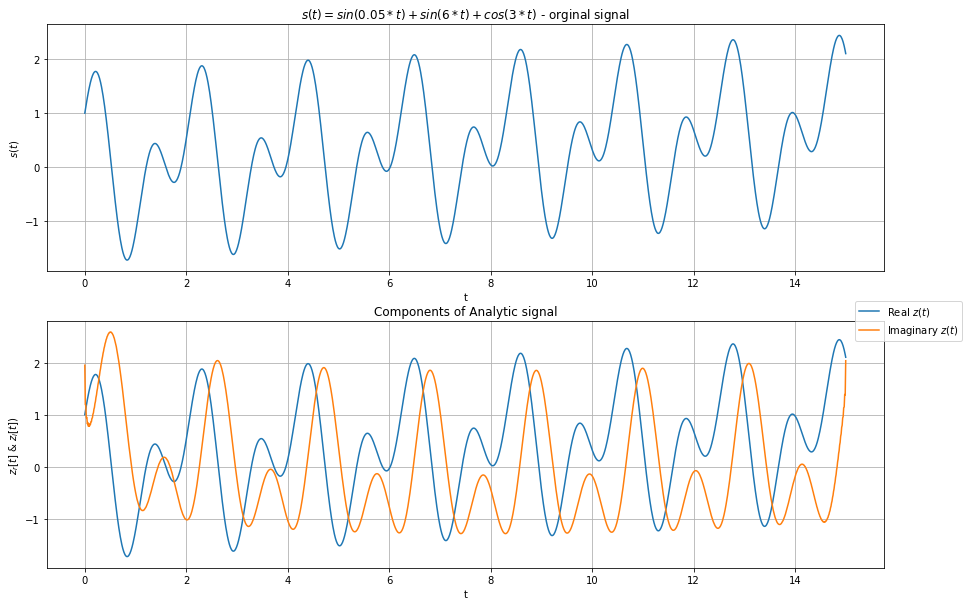

In [11]:
fig, ax = plt.subplots(2, 1,figsize=(15,10))

ax[0].title.set_text('$s(t)=sin(0.05*t) + sin(6*t) + cos(3*t)$ - orginal signal')
ax[0].plot( t, s )
ax[0].set_xlabel('t')
ax[0].set_ylabel('$s(t)$')
ax[0].grid()

ax[1].title.set_text('Components of Analytic signal')
ax[1].plot(t, hilbert(s).real, label = 'Real $z(t)$')
ax[1].plot(t, hilbert(s).imag, label = 'Imaginary $z(t)$')
ax[1].set_xlabel('t')
ax[1].set_ylabel('$z_r[t]$ & $z_i[t] )$')
ax[1].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
ax[1].grid()

plt.show()

### Empirical mode decomposition (EMD)

The EMD method is a necessary step to reduce any given data into a collection of intrinsic mode functions (IMF) to which the Hilbert spectral analysis can be applied.

IMF represents a simple oscillatory mode as a counterpart to the simple harmonic function, but it is much more general: instead of constant amplitude and frequency in a simple harmonic component, an IMF can have variable amplitude and frequency along the time axis.

The procedure of extracting an IMF is called sifting. The sifting process is as follows:

Identify all the local extrema in the test data.
Connect all the local maxima by a cubic spline line as the upper envelope.
Repeat the procedure for the local minima to produce the lower envelope

In [12]:
n_components = 4
# decompose signal into imfs and residue
emd = EMD(max_imfs=n_components)
emd.emd(s)
imfs, res = emd.get_imfs_and_residue()
n_components = imfs.shape[0] + 2

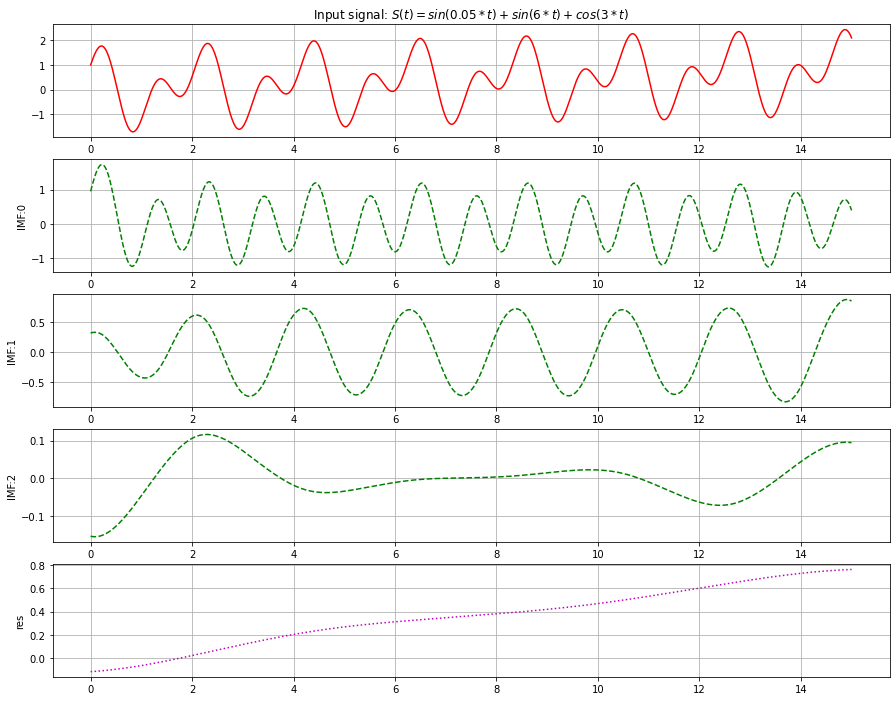

In [13]:
plt.figure(figsize=(15,12))
plt.subplot(n_components,1,1)
plt.plot(t, s, 'r')
plt.title("Input signal: $S(t)=sin(0.05*t) + sin(6*t) + cos(3*t)$")
plt.grid()

for n, imf in enumerate( imfs ):
    plt.subplot(n_components,1,n+2)
    plt.plot(t, imf, '--g')
    plt.ylabel('IMF:'+str(n))
    plt.grid()

n+=1
plt.subplot(n_components,1,n+2)
plt.plot(t, res, ':m')
plt.ylabel("res")
plt.grid()

#plt.savefig('simple_example')
plt.show()

### Reconstruct Original Signal
Retrieve original signal using IMF summation as below
$$E=r_n(t)\sum\limits_{i=1}^{n}IMF_i(t)$$

Residual of the signal, returned as a column vector or a single data column timetable. residual represents the portion of the original signal X not decomposed by emd.

residual is returned as:

A column vector, when X is a vector.

In [14]:
s_recomposition = invEMD(imfs,res)

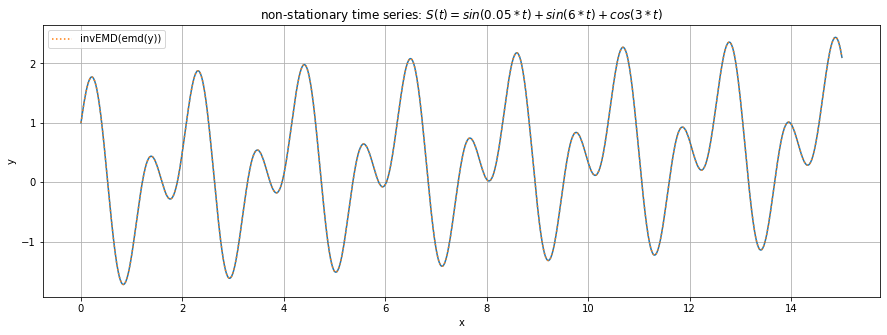

In [15]:
plt.figure(figsize=(15,5))
plt.title('non-stationary time series: $S(t)=sin(0.05*t) + sin(6*t) + cos(3*t)$')
plt.plot( t, s )
plt.plot( t, s_recomposition,":",label = "invEMD(emd(y))")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

### Hilbert–Huang transform

"The Hilbert–Huang transform (HHT) is a way to decompose a signal into so-called intrinsic mode functions (IMF) along with a trend, and obtain instantaneous frequency data. It is designed to work well for data that is nonstationary and nonlinear. In contrast to other common transforms like the Fourier transform, the HHT is an algorithm that can be applied to a data set, rather than a theoretical tool."


The HHT is a two stage process, the Python implementation of Empirical Mode Decomposition (EMD) which is incorperated here is from the [EMD-signal](https://pypi.org/project/EMD-signal/) library (*otherwise known as `PyEMD`*). The **hilbert transform** integrated in this implementation is from the [scipy](https://docs.scipy.org/doc/scipy/index.html) library (*specifically [scipy.signal.hilbert](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html)*). 


These core components combined with boiler plate python libraries such as numpy  

itself was implemented from scratch and is located in the src folder. 

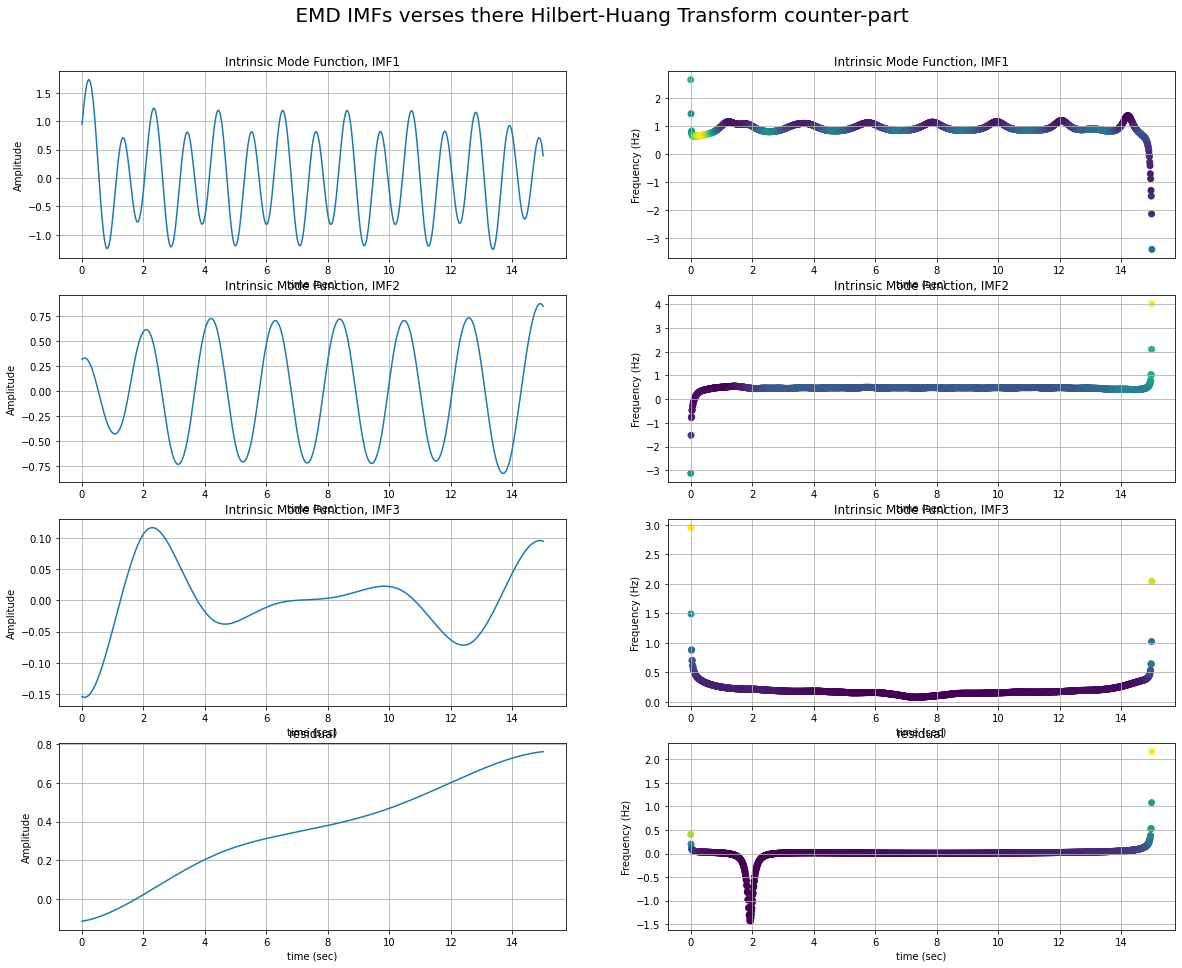

In [16]:
fig, axes = plt.subplots(n_components-1, 2, figsize=(20,15))
fig.suptitle(''' EMD IMFs verses there Hilbert-Huang Transform counter-part''', fontsize=20)
plt.subplots_adjust(top=0.92,hspace=0.2)

imf_freq_limit = [8,8,24,4]
freq_res = [0.1,0.01,0.01,0.01]

for n, (imf, freq_div) in enumerate( zip( imfs, imf_freq_limit) ):
    
    axes[n][0].title.set_text('Intrinsic Mode Function, IMF'+str(n+1))
    axes[n][0].plot( t, imf )
    axes[n][0].set_xlabel('time (sec)')
    axes[n][0].set_ylabel('Amplitude')
    axes[n][0].grid()
    
    T, F, P, insf, inse = hht(imf, fs, FResol= 0.1, freq_min = 0, freq_max = fs/freq_div)
    
    axes[n][1].title.set_text('Intrinsic Mode Function, IMF'+str(n+1))
    axes[n][1].scatter(T,insf, c = inse)
    # axes[n][1].pcolormesh(T,F, P.toarray(),cmap = my_cmap)
    axes[n][1].set_xlabel('time (sec)')
    axes[n][1].set_ylabel('Frequency (Hz)')
    axes[n][1].grid()

axes[n+1][0].title.set_text('residual')
axes[n+1][0].plot( t, res )
axes[n+1][0].set_xlabel('time (sec)')
axes[n+1][0].set_ylabel('Amplitude')
axes[n+1][0].grid()
    
T, F, P, insf, inse = hht(res, fs, FResol= 0.1, freq_min = 0, freq_max = fs/30)

axes[n+1][1].title.set_text('residual')
axes[n+1][1].scatter(T,insf, c = inse)
axes[n+1][1].set_xlabel('time (sec)')
axes[n+1][1].set_ylabel('Frequency (Hz)')
axes[n+1][1].grid()

plt.show()

In [17]:
my_cmap = color_map()

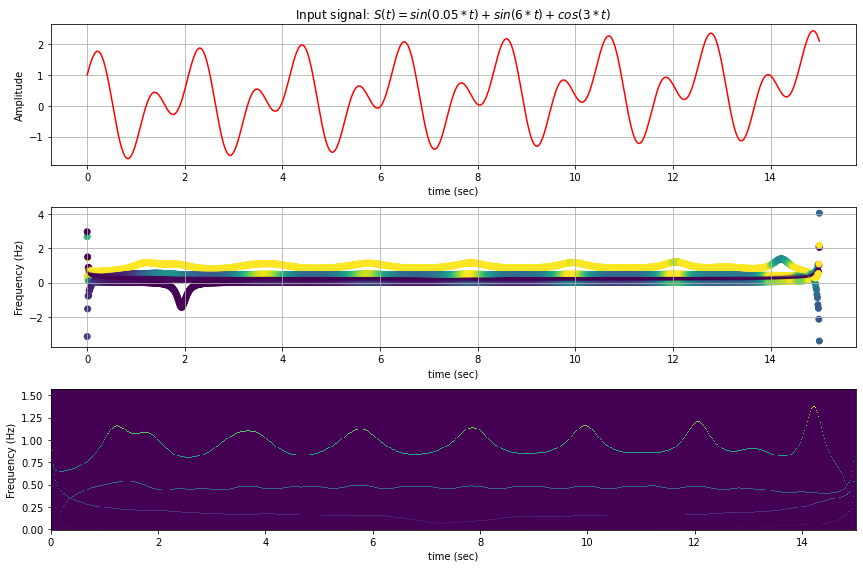

In [18]:
fig, ax = plt.subplots(3, 1,figsize=(12,8))

ax[0].plot(t, s, 'r')
ax[0].title.set_text("Input signal: $S(t)=sin(0.05*t) + sin(6*t) + cos(3*t)$")
ax[0].set_ylabel('Amplitude')
ax[0].set_xlabel('time (sec)')
ax[0].grid()

T, F, spec_2d, spec_1d = Hilbert_spectrum(s, fs, freq_div = 64, 
                                n_components = 4, 
                                frequency_resolution = .01)

for spec in spec_1d:
    ax[1].scatter(spec[0],spec[1], c = spec[2])

ax[1].set_xlabel('time (sec)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].grid()

ax[2].pcolormesh(T, F, spec_2d)

ax[2].set_xlabel('time (sec)')
ax[2].set_ylabel('Frequency (Hz)')
plt.tight_layout()
#plt.savefig('simple_example')
plt.show()

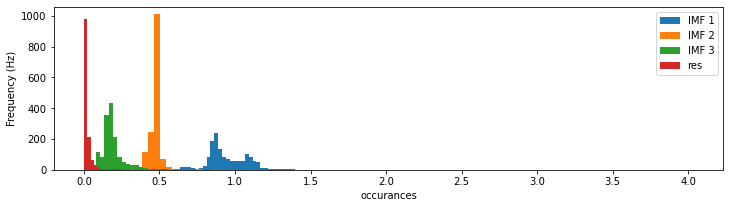

In [19]:
plt.figure(figsize=(12,3))

for n, imf in enumerate( imfs ):
    
    T, F, P, insf, inse = hht(imf, fs, FResol= 0.1, freq_min = 0, freq_max = fs/8)
    plt.hist(P.toarray()[P.toarray() != 0],bins = 100, label = 'IMF '+ str(n+1))
    
T, F, P, insf, inse = hht(res, fs, FResol= 0.1, freq_min = 0, freq_max = fs/30)
plt.hist(P.toarray()[P.toarray() != 0],bins = 100, label = 'res')
plt.xlabel('occurances')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.show()

### load in Physiologic Waveforms


We will use patient **p000188** to verify our process as this patient as a number of ICU admissions (similar to a number of patients in the mimic datset) and we will need to identify a single ICU admission to extract our final dataset form. 

In [20]:
# load in Physiologic Waveforms
ppg = pd.read_hdf('./data/physiological_signals.h5', key='ppg', mode='r')
ecg = pd.read_hdf('./data/physiological_signals.h5', key='ecg', mode='r')
abp = pd.read_hdf('./data/physiological_signals.h5', key='abp', mode='r')

fs = 125
# build elapsed time vector, used for plotting - (number of columns = lenght of waveform segiments)
t = np.linspace(0, (ppg.shape[1])*(1/fs), num=(ppg.shape[1]))
# Get shape of Waveform datasets
ppg.shape, ecg.shape, abp.shape

((3, 5000), (3, 5000), (3, 5000))

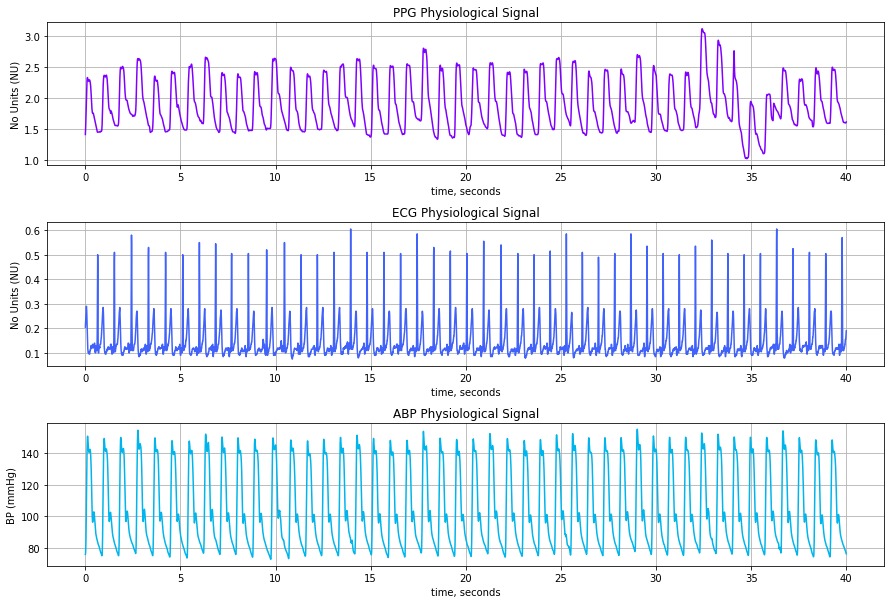

In [21]:
for sig in range(1):
    
    fig, axes = plt.subplots(3, 1, figsize=(15,10))
    plt.subplots_adjust(hspace=0.4)

    color = cm.rainbow(np.linspace(0,1,9))

    axes[0].title.set_text('PPG Physiological Signal')
    axes[0].plot(t,ppg.values[sig],color=color[0])
    axes[0].set_xlabel('time, seconds')
    axes[0].set_ylabel('No Units (NU)')
    axes[0].grid()

    axes[1].title.set_text('ECG Physiological Signal')
    axes[1].plot(t,ecg.values[sig],color=color[1])
    axes[1].set_xlabel('time, seconds')
    axes[1].set_ylabel('No Units (NU)')
    axes[1].grid()

    axes[2].title.set_text('ABP Physiological Signal')
    axes[2].plot(t,abp.values[sig],color=color[2])
    axes[2].set_xlabel('time, seconds')
    axes[2].set_ylabel('BP (mmHg)')
    axes[2].grid()
    plt.show()

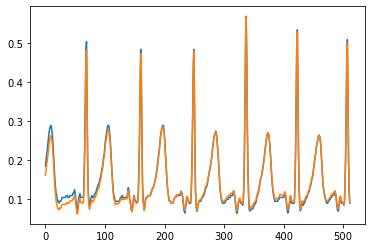

In [22]:
n_components = 4
s1 = ecg.values[1]
plt.plot(s1[:512])
s1 = denoise_biowave( s1, fs = fs, mode = 'orginal_dc' )
plt.plot(s1[:512])
s1 = s1[:512]
t = np.linspace(0, (s1.shape[0])*(1/fs), num=(s1.shape[0]))

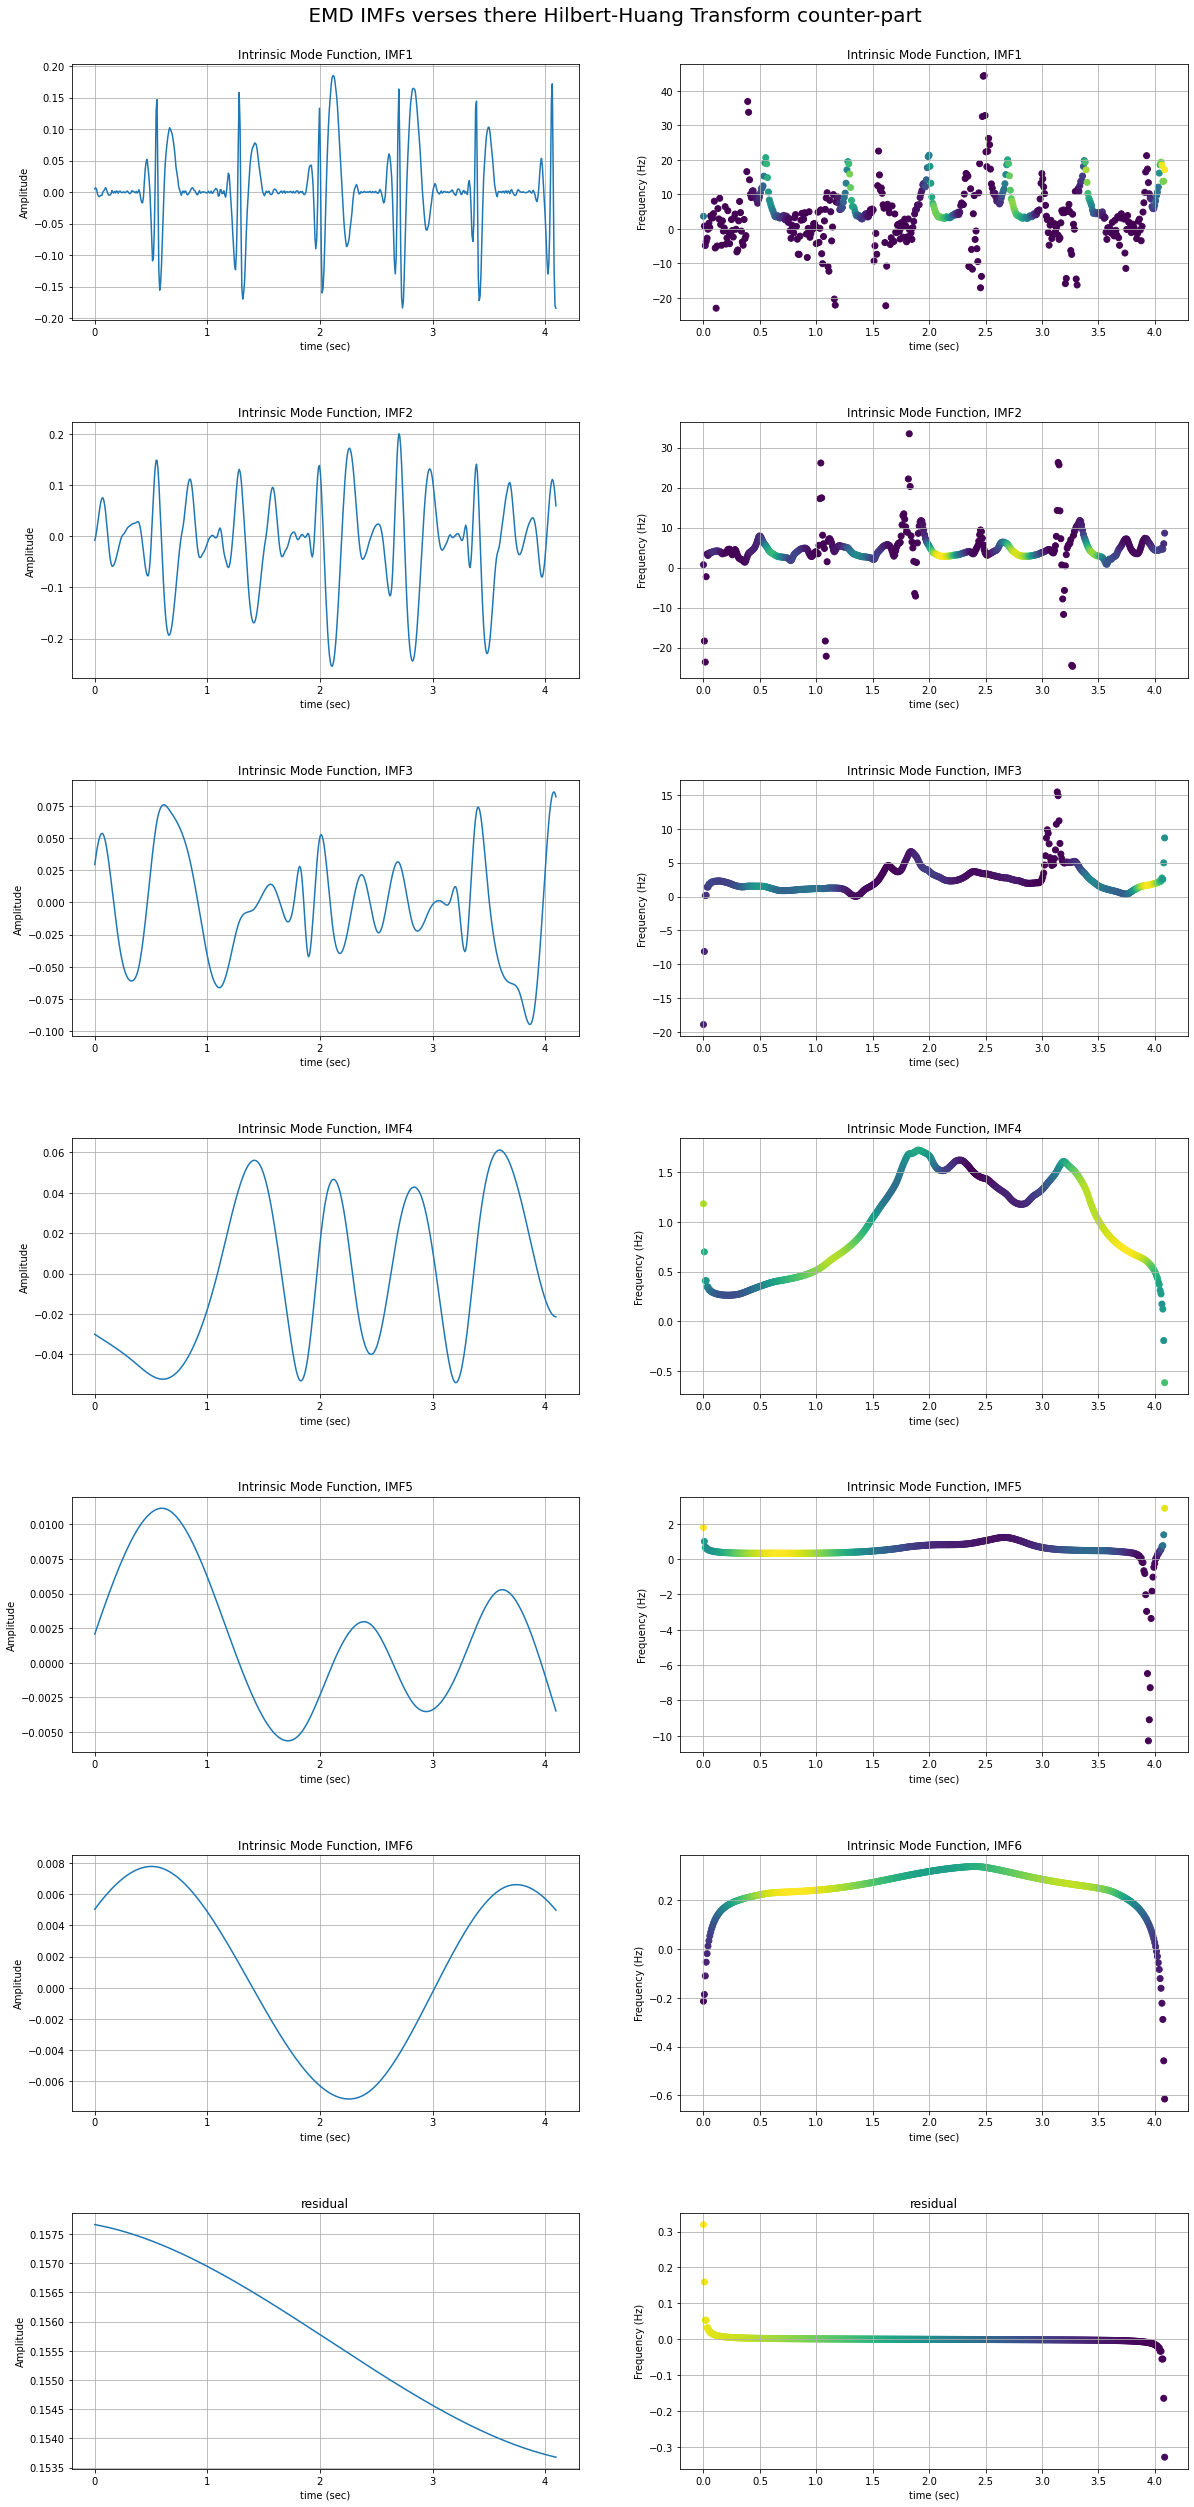

In [23]:
# decompose signal into imfs and residue
emd = EMD(max_imfs=n_components)
emd.emd(s1)
imfs, res = emd.get_imfs_and_residue()
n_components = imfs.shape[0] + 2

fig, axes = plt.subplots(n_components - 1, 2, figsize=(20,40))
fig.suptitle(''' EMD IMFs verses there Hilbert-Huang Transform counter-part''', fontsize=20)
plt.subplots_adjust(top=0.96,hspace=0.4)
# plt.tight_layout()

for n, imf in enumerate(imfs):
    
    axes[n][0].title.set_text('Intrinsic Mode Function, IMF'+str(n+1))
    axes[n][0].plot( t, imf )
    axes[n][0].set_xlabel('time (sec)')
    axes[n][0].set_ylabel('Amplitude')
    axes[n][0].grid()
    
    T, F, P, insf, inse = hht(imf, fs, FResol= 0.1, freq_min = 0, freq_max = fs/2)
    
    axes[n][1].title.set_text('Intrinsic Mode Function, IMF'+str(n+1))
    axes[n][1].scatter(T,insf, c = inse)
    axes[n][1].set_xlabel('time (sec)')
    axes[n][1].set_ylabel('Frequency (Hz)')
    axes[n][1].grid()

axes[n+1][0].title.set_text('residual')
axes[n+1][0].plot( t, res )
axes[n+1][0].set_xlabel('time (sec)')
axes[n+1][0].set_ylabel('Amplitude')
axes[n+1][0].grid()
    
T, F, P, insf, inse = hht(res, fs, FResol= 0.1, freq_min = 0, freq_max = fs/30)

axes[n+1][1].title.set_text('residual')
axes[n+1][1].scatter(T,insf, c = inse)
axes[n+1][1].set_xlabel('time (sec)')
axes[n+1][1].set_ylabel('Frequency (Hz)')
axes[n+1][1].grid()


plt.show()

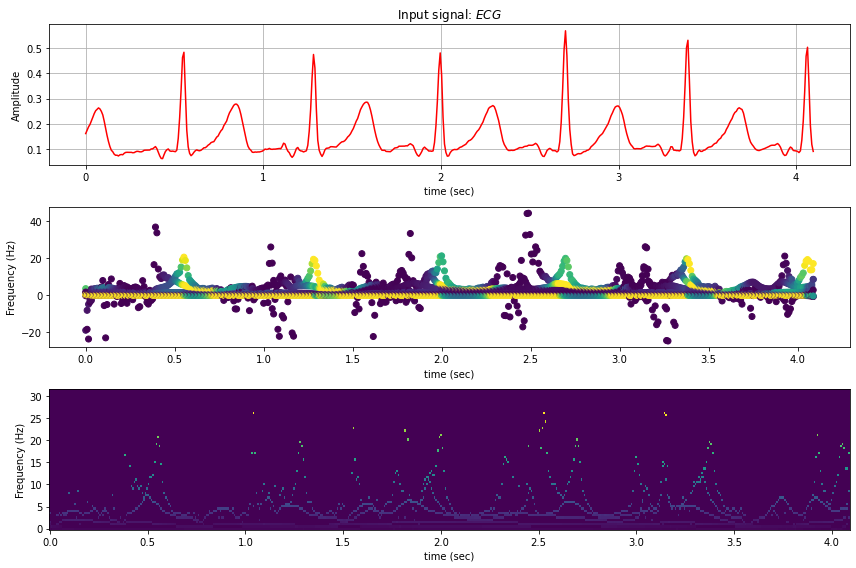

In [24]:
fig, ax = plt.subplots(3, 1,figsize=(12,8))

ax[0].plot(t, s1, 'r')
ax[0].title.set_text("Input signal: $ECG$")
ax[0].set_ylabel('Amplitude')
ax[0].set_xlabel('time (sec)')
ax[0].grid()

T, F, spec_2d, spec_1d = Hilbert_spectrum(s1, fs, freq_div = 4, 
                                n_components = 2, 
                                frequency_resolution = .5)

for spec in spec_1d:
    ax[1].scatter(spec[0],spec[1], c = spec[2])

ax[1].set_xlabel('time (sec)')
ax[1].set_ylabel('Frequency (Hz)')

ax[2].pcolormesh(T, F, spec_2d)#, 
                 #cmap = my_cmap)

ax[2].set_xlabel('time (sec)')
ax[2].set_ylabel('Frequency (Hz)')
plt.tight_layout()
#plt.savefig('simple_example')
plt.show()

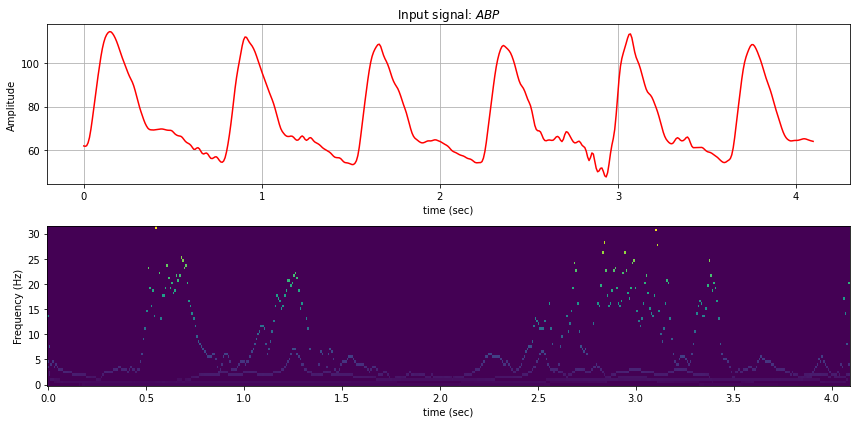

In [25]:
s2 = abp.values[1]
s2 = denoise_biowave( s2, fs = fs, mode = 'orginal_dc' )
s2 = s2[:512]
t = np.linspace(0, (s2.shape[0])*(1/fs), num=(s2.shape[0]))

fig, ax = plt.subplots(2, 1,figsize=(12,6))

ax[0].plot(t, s2, 'r')
ax[0].title.set_text("Input signal: $ABP$")
ax[0].set_ylabel('Amplitude')
ax[0].set_xlabel('time (sec)')
ax[0].grid()

T, F, spec_2d, spec_1d = Hilbert_spectrum(s2, fs, freq_div = 4, 
                                n_components = 2, 
                                frequency_resolution = .5)


ax[1].pcolormesh(T, F, spec_2d)
ax[1].set_xlabel('time (sec)')
ax[1].set_ylabel('Frequency (Hz)')
plt.tight_layout()
#plt.savefig('simple_example')
plt.show()

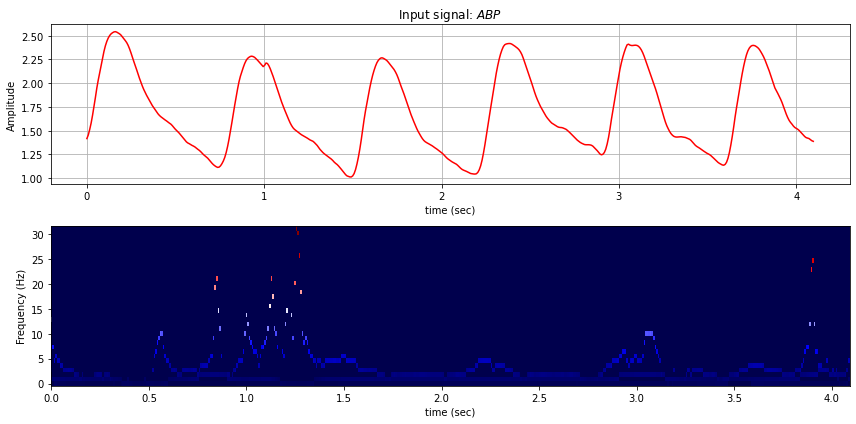

In [26]:
s3 = denoise_biowave( ppg.values[1], fs = fs, mode = 'orginal_dc' )[:512]
t = np.linspace(0, (s3.shape[0])*(1/fs), num=(s2.shape[0]))

fig, ax = plt.subplots(2, 1,figsize=(12,6))

ax[0].plot(t, s3, 'r')
ax[0].title.set_text("Input signal: $ABP$")
ax[0].set_ylabel('Amplitude')
ax[0].set_xlabel('time (sec)')
ax[0].grid()

T, F, spec_2d, spec_1d = Hilbert_spectrum(s3, fs, freq_div = 4, 
                                n_components = 2, 
                                frequency_resolution = .9)


ax[1].pcolormesh(T, F, spec_2d, cmap= plt.cm.seismic)
ax[1].set_xlabel('time (sec)')
ax[1].set_ylabel('Frequency (Hz)')
plt.tight_layout()
#plt.savefig('simple_example')
plt.show()

## Loading the UCI-HAR time-series dataset

In [3]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

def read_signals_ucihar(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data
 
def read_labels_ucihar(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return activities
 
def load_ucihar_data(folder):
    
    train_folder = folder + 'train/Inertial Signals/'
    test_folder = folder + 'test/Inertial Signals/'
    labelfile_train = folder + 'train/y_train.txt'
    labelfile_test = folder + 'test/y_test.txt'
    
    train_signals, test_signals, sig_names = [], [], []
    for input_file in os.listdir(train_folder):
        sig_names.extend( [input_file.split('_train')[0] ])
        signal = read_signals_ucihar(train_folder + input_file)
        train_signals.append(signal)
        
    train_signals = np.transpose(np.array(train_signals), (1, 2, 0))
    for input_file in os.listdir(test_folder):
        signal = read_signals_ucihar(test_folder + input_file)
        test_signals.append(signal)
        
    test_signals = np.transpose(np.array(test_signals), (1, 2, 0))
    train_labels = np.array(read_labels_ucihar(labelfile_train))
    test_labels = np.array( read_labels_ucihar(labelfile_test) )
    
    return train_signals, train_labels, test_signals, test_labels, sig_names
 
folder_ucihar = './data/UCI HAR Dataset/' 
X_trainVal, y_trainVal, X_test, y_test, sig_names = load_ucihar_data(folder_ucihar)

In [4]:
train_subject_ids = pd.read_table('./data/UCI HAR Dataset/train/subject_train.txt', header=None, names=['SubjectID']).values.flatten()
test_subject_ids = pd.read_table('./data/UCI HAR Dataset/test/subject_test.txt', header=None, names=['SubjectID']).values.flatten()

C:\ProgramData\Anaconda3\envs\hht-ml\lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


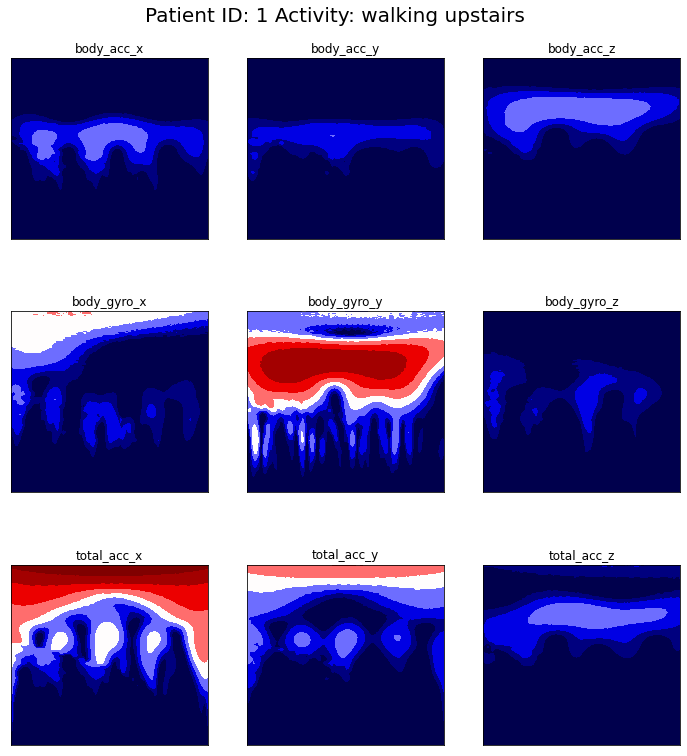

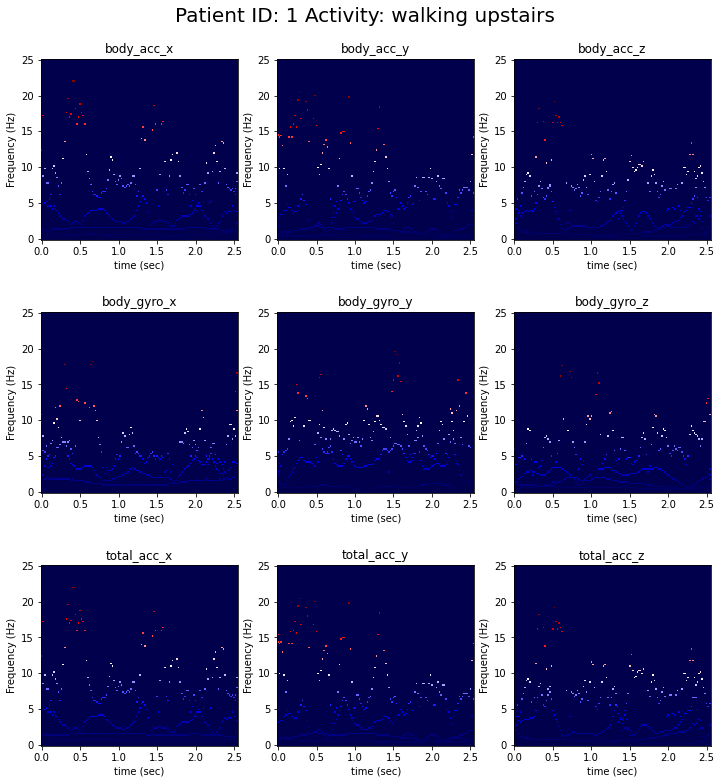

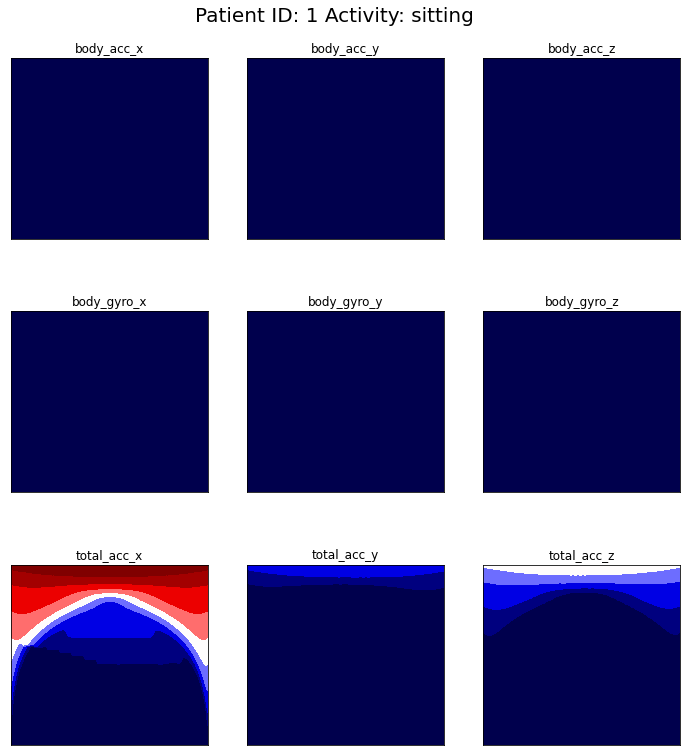

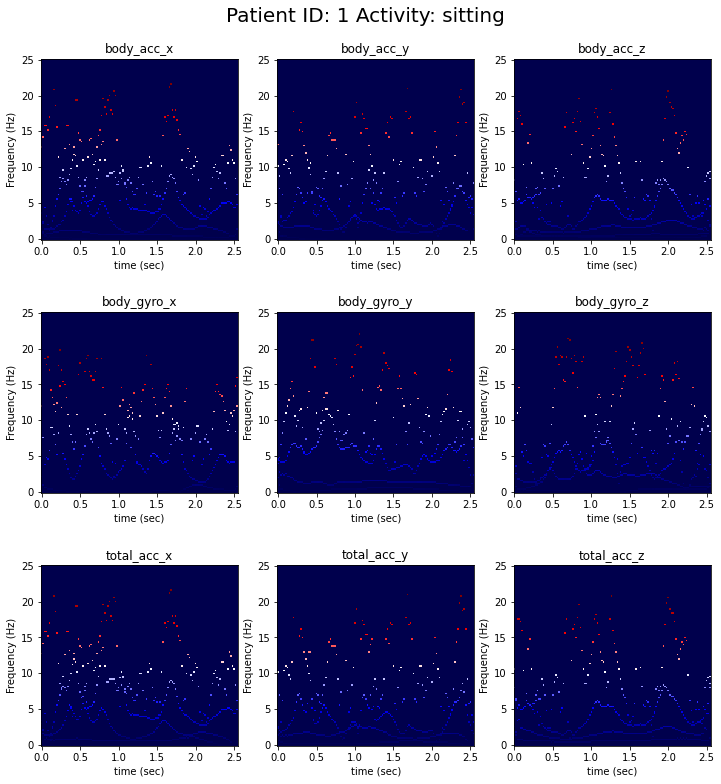

In [5]:
N = 128
t0=0
dt=0.25
time = np.arange(0, N) * dt + t0
fs = 50    
patient_id = 1
spec_activities = {
    2: 'walking upstairs',
    4: 'sitting'
}

for activitiy in spec_activities.keys():
    
    # Aquire data for selected patient slected through patient ID
    patient_labels = y_trainVal[np.where(train_subject_ids == patient_id)[0]]
    patient_signals = X_trainVal[np.where(train_subject_ids == patient_id)[0]]
    
    # Get all indexs where this patient is conducting the desired activitiy
    act_indxs = np.argwhere(patient_labels == activitiy).flatten()
    # Randomly sample from this set of indexs where the patient is conducting the desired activitiy
    indx = np.random.choice(act_indxs, 1)[0]
    
    scales = np.arange(1, 128)
    # plot Wavelet
    fig, axes = plt.subplots(3, 3, figsize=(12,12))
    fig.suptitle("Patient ID: "+str(patient_id)+" Activity: " + activities_description[activitiy], fontsize=20)
    plt.subplots_adjust(top=0.92,hspace=0.4)

    v, h = -1, 0 
    for i, signal in enumerate( patient_signals[indx].T ):
        if i % 3 == 0:
            v+=1
            h = 0
        else:
            h+=1
        plot_wavelet(axes[v][h], time, signal, scales, title=sig_names[i])
    plt.show()
    
    
    # plot HHT
    fig, axes = plt.subplots(3, 3, figsize=(12,12))
    fig.suptitle("Patient ID: "+str(patient_id)+" Activity: " + activities_description[activitiy], fontsize=20)
    plt.subplots_adjust(top=0.92,hspace=0.4)

    v, h = -1, 0 
    for i, signal in enumerate( patient_signals[indx].T ):
        if i % 3 == 0:
            v+=1
            h = 0
        else:
            h+=1
        plot_HHT(axes[v][h], fs, signal, title = sig_names[i])
    plt.show()

In [6]:
from sklearn.model_selection import StratifiedKFold

In [7]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Flatten, Conv1DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from keras.callbacks import History 
from tensorflow.keras.utils import plot_model
import tensorflow as tf

class cwt_cnn(object):
    def __init__(self, img_x = 127, img_y= 127, n_inputs = 9, 
                 num_classes = 6, model_name = "CWT", learning_rate = 0.001 ):
        
        # define model for neural network 
        cwt_input = Input(shape=(img_x, img_y, n_inputs), name='cwt_image')
        x = Conv2D(filters=32, kernel_size=(5, 5), padding="same", 
                   strides = (1, 1), activation="relu", 
                   name='e')(cwt_input)
        x = BatchNormalization()(x)
        # x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
        x = Conv2D(filters=64, kernel_size=(5, 5), padding="same", 
                   strides=(2, 2), activation="relu",name='l')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Flatten()(x)
        x = Dense(1000, activation='relu')(x)
        x = Dropout(rate=0.2)(x)
        cwt_out = Dense(num_classes, activation='softmax')(x)
        
        model = Model(cwt_input, cwt_out, name=model_name)
        
        opt = Adam(learning_rate=learning_rate)
        model.compile(loss=categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])
        self.model = model
        
    def summery(self):
        return self.model.summary()
    
    def view_model(self):
        return plot_model(self.model)

In [8]:
cwt = cwt_cnn()
print(cwt.summery())

Model: "CWT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cwt_image (InputLayer)      [(None, 127, 127, 9)]     0         
                                                                 
 e (Conv2D)                  (None, 127, 127, 32)      7232      
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 32)     128       
 ormalization)                                                   
                                                                 
 l (Conv2D)                  (None, 64, 64, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0       

In [9]:
# cwt.view_model()

import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 
history = History()

In [10]:
scales = range(1,128)
waveletname = 'morl'

X = np.ndarray(shape=(X_trainVal.shape[0], 127, 127, 9))

for i in range(X_trainVal.shape[0]):
    for j in range(X_trainVal.T.shape[0]):
        coeff, freq = pywt.cwt(X_trainVal[i, :, j], scales, waveletname, 1)
        X[i, :, :, j] = coeff[:,:127]

In [ ]:
num_classes = 6
batch_size = 16
epochs = 10

skf = StratifiedKFold( n_splits = 10, shuffle=False )
skf.get_n_splits(X_trainVal, y_trainVal)

for train_index, test_index in skf.split(X_trainVal, y_trainVal):

    X_train, X_Val = X[train_index], X[test_index]
    y_train, y_Val = y_trainVal[train_index], y_trainVal[test_index]
    
    # The values of the label are out of range as it starts at 1 and not 0
    y_train = keras.utils.to_categorical(y_train-1, num_classes)
    y_Val = keras.utils.to_categorical(y_Val-1, num_classes)
    
    history = History()
    # aquire model with random weights
    model = cwt_cnn()
    model.model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_Val, y_Val), 
          callbacks=[history])
    
    break


Epoch 1/10
414/414 [==============================] - 199s 474ms/step - loss: 5.4303 - accuracy: 0.8597 - val_loss: 1.0875 - val_accuracy: 0.9457
Epoch 2/10
299/414 [====================>.........] - ETA: 54s - loss: 0.6342 - accuracy: 0.9093

In [39]:
train_score = model.model.evaluate(X_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.model.evaluate(X_Val, y_Val, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Train loss: 0.04098699241876602, Train accuracy: 0.9801995158195496
Test loss: 0.22614341974258423, Test accuracy: 0.96875


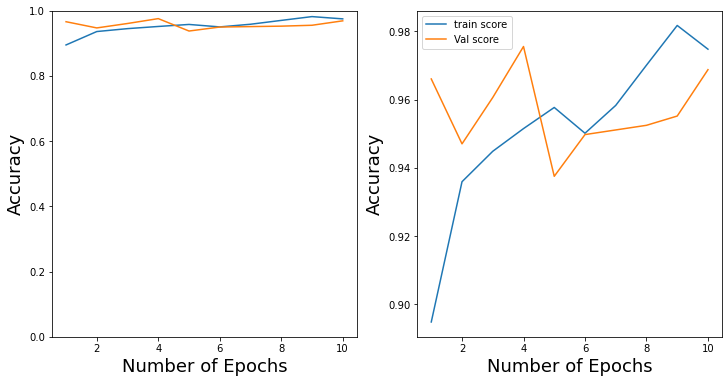

In [45]:
fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
axarr[0].plot(range(1, 11), history.history['accuracy'], label='train score')
axarr[0].plot(range(1, 11), history.history['val_accuracy'], label='Val score')
axarr[0].set_xlabel('Number of Epochs', fontsize=18)
axarr[0].set_ylabel('Accuracy', fontsize=18)
axarr[0].set_ylim([0,1])
axarr[1].plot(range(1, 11), history.history['accuracy'], label='train score')
axarr[1].plot(range(1, 11), history.history['val_accuracy'], label='Val score')
axarr[1].set_xlabel('Number of Epochs', fontsize=18)
axarr[1].set_ylabel('Accuracy', fontsize=18)
#axarr[1].set_ylim([0.9,1])
plt.legend()
plt.show()

In [47]:
fs

50

In [68]:
X = np.ndarray(shape=(X_trainVal.shape[0], 126, 128, 9))

for i in range(X_trainVal.shape[0]):
    for j in range(X_trainVal.T.shape[0]):
        T, F, spec_2d, spec_1d = Hilbert_spectrum(X_trainVal[i, :, j], fs, freq_div = 2, 
                                n_components = 8, 
                                frequency_resolution = .2)
        X[i, :, :, j] = spec_2d


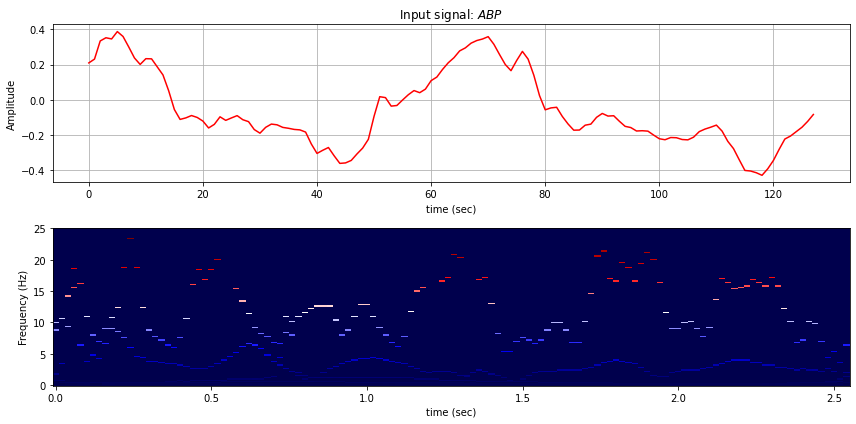

In [63]:
fig, ax = plt.subplots(2, 1,figsize=(12,6))

ax[0].plot( X_trainVal[i, :, j], 'r')
ax[0].title.set_text("Input signal: $ABP$")
ax[0].set_ylabel('Amplitude')
ax[0].set_xlabel('time (sec)')
ax[0].grid()


ax[1].pcolormesh(T, F, spec_2d, cmap= plt.cm.seismic)
ax[1].set_xlabel('time (sec)')
ax[1].set_ylabel('Frequency (Hz)')
plt.tight_layout()
#plt.savefig('simple_example')
plt.show()

In [66]:
X.shape

(7352, 126, 128, 9)

In [70]:
num_classes = 6
batch_size = 16
epochs = 10

skf = StratifiedKFold( n_splits = 10, shuffle=False )
skf.get_n_splits(X_trainVal, y_trainVal)

for train_index, test_index in skf.split(X_trainVal, y_trainVal):

    X_train, X_Val = X[train_index], X[test_index]
    y_train, y_Val = y_trainVal[train_index], y_trainVal[test_index]
    
    # The values of the label are out of range as it starts at 1 and not 0
    y_train = keras.utils.to_categorical(y_train-1, num_classes)
    y_Val = keras.utils.to_categorical(y_Val-1, num_classes)
    
    history = History()
    # aquire model with random weights
    model = cwt_cnn(img_x = 126, img_y= 128)
    model.model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_Val, y_Val), 
          callbacks=[history])
    
    break

Epoch 1/10
414/414 [==============================] - 75s 178ms/step - loss: 1.5300 - accuracy: 0.3294 - val_loss: 1.2153 - val_accuracy: 0.3723
Epoch 2/10
414/414 [==============================] - 80s 192ms/step - loss: 1.1035 - accuracy: 0.4686 - val_loss: 1.1619 - val_accuracy: 0.4361
Epoch 3/10
414/414 [==============================] - 86s 207ms/step - loss: 0.8116 - accuracy: 0.6460 - val_loss: 1.3251 - val_accuracy: 0.4130
Epoch 4/10
414/414 [==============================] - 83s 202ms/step - loss: 0.3410 - accuracy: 0.8720 - val_loss: 2.0212 - val_accuracy: 0.4062
Epoch 5/10
414/414 [==============================] - 84s 203ms/step - loss: 0.0746 - accuracy: 0.9778 - val_loss: 2.8437 - val_accuracy: 0.3940
Epoch 6/10
414/414 [==============================] - 85s 204ms/step - loss: 0.0185 - accuracy: 0.9950 - val_loss: 3.5558 - val_accuracy: 0.4158
Epoch 7/10
414/414 [==============================] - 92s 222ms/step - loss: 0.0170 - accuracy: 0.9961 - val_loss: 3.2905 - val_ac

In [71]:
train_score = model.model.evaluate(X_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.model.evaluate(X_Val, y_Val, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Train loss: 0.08736731857061386, Train accuracy: 0.9737001061439514
Test loss: 4.060168743133545, Test accuracy: 0.3899456560611725


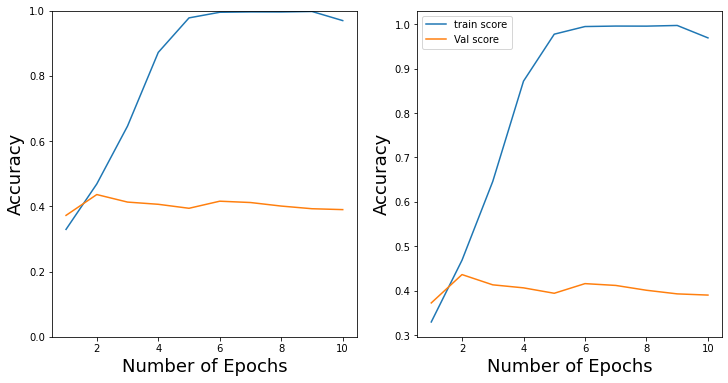

In [72]:
fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
axarr[0].plot(range(1, 11), history.history['accuracy'], label='train score')
axarr[0].plot(range(1, 11), history.history['val_accuracy'], label='Val score')
axarr[0].set_xlabel('Number of Epochs', fontsize=18)
axarr[0].set_ylabel('Accuracy', fontsize=18)
axarr[0].set_ylim([0,1])
axarr[1].plot(range(1, 11), history.history['accuracy'], label='train score')
axarr[1].plot(range(1, 11), history.history['val_accuracy'], label='Val score')
axarr[1].set_xlabel('Number of Epochs', fontsize=18)
axarr[1].set_ylabel('Accuracy', fontsize=18)
#axarr[1].set_ylim([0.9,1])
plt.legend()
plt.show()

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html
https://uk.mathworks.com/help/signal/ug/hilbert-transform.html
https://towardsdatascience.com/instantaneous-phase-and-magnitude-with-the-hilbert-transform-40a73985be07
https://www.sciencedirect.com/topics/engineering/hilbert-transform
https://www.comm.utoronto.ca/frank/notes/hilbert.pdf


https://www.gaussianwaves.com/2017/04/analytic-signal-hilbert-transform-and-fft/
https://www.comm.utoronto.ca/frank/notes/hilbert.pdf

https://www.gaussianwaves.com/2015/11/interpreting-fft-results-complex-dft-frequency-bins-and-fftshift/

file:///C:/Users/ebolger2/Downloads/energies-10-00188-v2.pdf

https://www.researchgate.net/post/What_is_the_difference_between_wavelet_transform_and_Hilbert-Huang_transform#:~:text=Wavelet%20transform%20convolves%20a%20signal,basis%20function%20or%20mother%20wavelet.

https://www.kaggle.com/code/asauve/a-gentle-introduction-to-wavelet-for-data-analysis/notebook

https://dsp.stackexchange.com/questions/69614/inverse-hilbert-transform

https://pyhht.readthedocs.io/en/latest/tutorials/hilbert_view_nonlinearity.html

https://www.tandfonline.com/doi/abs/10.1080/00423110802167466

https://fairyonice.github.io/implement-the-spectrogram-from-scratch-in-python.html

https://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/
https://archive.ics.uci.edu/ml/index.php
https://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/

https://github.com/taspinar/siml/tree/master/notebooks
https://github.com/taspinar/siml/blob/master/notebooks/WV2%20-%20Visualizing%20the%20Scaleogram%2C%20time-axis%20and%20Fourier%20Transform.ipynb
https://github.com/taspinar/siml/blob/master/notebooks/WV3%20-%20Classification%20of%20signals%20using%20the%20CWT%20and%20CNN.ipynb
https://notebook.community/Mashimo/datascience/00-tidyData/CleanDataHAR

In [77]:
np.random.shuffle(train_index)
#train_index

In [78]:
y_trainVal[train_index][0:10]

array([4, 4, 5, 1, 1, 2, 6, 4, 6, 1])

# References

**Fast Fourier Transform**
* Cooley, James W., and John W. Tukey, 1965, “An algorithm for the machine calculation of complex Fourier series,” Math. Comput. 19: 297-301.

* Bluestein, L., 1970, “A linear filtering approach to the computation of discrete Fourier transform”. IEEE Transactions on Audio and Electroacoustics. 18 (4): 451-455.

* D. Gabor, “Theory of communications”, Journal of the Inst. Electr. Eng., vol. 93, pt. 111, pp. 42-57, 1946. See definition of complex signal on p. 432.

* J. A. Ville, “Theorie et application de la notion du signal analytique”, Cables el Transmission, vol. 2, [pp. 61-74, 1948](https://ieeexplore.ieee.org/document/1163127).


The Fourier transform generalizes Fourier coefficients of a signal over time. Since the Fourier coefficients are the measures of the signal amplitude as a function of frequency, the time information is totally lost. 

A powerful variant of the Fourier transform is the wavelet transform. By using finite-support basis functions, wavelets are able to approximate even nonstationary data. These basis functions possess most of the desirable properties required for linear decomposition (like orthogonality, completeness , etc) and they can be drawn from a large dictionary of wavelets. This makes the wavelet transform a versatile tool for analysis of nonstationary data. But the wavelet transform is still a linear decomposition and hence suffers from related problems like the uncertainty principle. Moreover, like Fourier, the wavelet transform too is non-adaptive. The basis functions are selected a priori and consequently make the wavelet decomposition prone to spurious harmonics and ultimately incorrect interpretations of the data.

A remarkable advantage of Fourier based methods is their mathematical framework. Fourier based methods are so elegant that they make building models for a given dataset very easy. Although such models can represent most of the data and are extensive enough for a practical application, the fact remains that there is some amount of data slipping through the gaps left behind by linear approximations. Despite all these shortcomings, wavelet analysis still remains the best possible method for analysis of nonstationary data, and hence should be used as a reference to establish the validity of other methods.

The Hilbert-Huang transform is an algorithm developed empirically to overcome these short commings, however there is no well-defined mathematical base. All inferences drawn from it are empirical and can only be corroborated as such. It lacks the mathematical sophistication of the Fourier framework. On the plus side it provides a very realistic insight into data.

Thus here we have room for a tradeoff between the mathematical elegance of the Fourier analysis and the physical significance provided by the Hilbert-Huang transform. Wavelets are the closest thing to the HHT that not only have the ability to analyze nonlinear and nonstationary phenomena, but also a complete mathematical foundation. Unfortunately wavelets are not adaptive and as such might suffer from problems like uncertainty principle, leakages, Gibb’s phenomenon, harmonics, etc - like most of the decomposition techniques that use a priori basis functions.